- 참조 사이트 : https://dsstudy.tistory.com/m/10

In [1]:
# 경고창무시
import warnings
warnings.filterwarnings('ignore') 

# data analysis and wrangling
import pandas as pd
import numpy as np

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df_price = pd.read_csv('/content/01-삼성전자-주가.csv', encoding='utf8')
df_price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9288 entries, 0 to 9287
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   일자      9288 non-null   int64
 1   시가      9288 non-null   int64
 2   고가      9288 non-null   int64
 3   저가      9288 non-null   int64
 4   종가      9288 non-null   int64
 5   거래량     9288 non-null   int64
dtypes: int64(6)
memory usage: 435.5 KB


In [3]:
df_price.describe()

,일자,시가,고가,저가,종가,거래량
count,9.288000e+03,9288.000000,9288.000000,9288.000000,9288.000000,9.288000e+03
mean,2.001347e+07,11108.556417,11228.754522,10986.106481,11108.235465,1.645823e+07
std,1.015376e+05,13792.646300,13920.105135,13658.809496,13790.922497,1.701535e+07
min,1.985010e+07,116.000000,116.000000,115.000000,116.000000,0.000000e+00
25%,1.992121e+07,624.000000,632.000000,620.000000,623.000000,3.833986e+06
50%,2.001032e+07,5045.000000,5190.000000,4955.000000,5075.000000,1.199608e+07
75%,2.010080e+07,15920.000000,16050.000000,15740.000000,15920.000000,2.284080e+07
max,2.020011e+07,57500.000000,57520.000000,56760.000000,57220.000000,3.266220e+08


컬럼은 [일자, 시가, 고가, 저가, 종가, 거래량]으로 구성된 매우 단순한 데이터 셋입니다.

 총 9,288개의 row로 구성되어 있네요. 우리는 일자, 시가, 고가, 저가, 거래량을 토대로 미래의 주가인 "종가"를 예측해 보도록 하겠습니다.

 ## 날짜 datetime 포맷으로 변환

In [4]:
pd.to_datetime(df_price['일자'], format='%Y%m%d')
# 0      2020-01-07
# 1      2020-01-06
# 2      2020-01-03
# 3      2020-01-02
# 4      2019-12-30

df_price['일자'] = pd.to_datetime(df_price['일자'], format='%Y%m%d')
df_price['연도'] =df_price['일자'].dt.year
df_price['월'] =df_price['일자'].dt.month
df_price['일'] =df_price['일자'].dt.day

In [5]:
df_price.head()

,일자,시가,고가,저가,종가,거래량,연도,월,일
0,2020-01-07,55700,56400,55600,55800,9893846,2020,1,7
1,2020-01-06,54900,55600,54600,55500,10278951,2020,1,6
2,2020-01-03,56000,56600,54900,55500,15422255,2020,1,3
3,2020-01-02,55500,56000,55000,55200,12993228,2020,1,2
4,2019-12-30,56200,56600,55700,55800,8356767,2019,12,30


## 1990년도 이후의 주가 시각화

Text(0, 0.5, 'price')

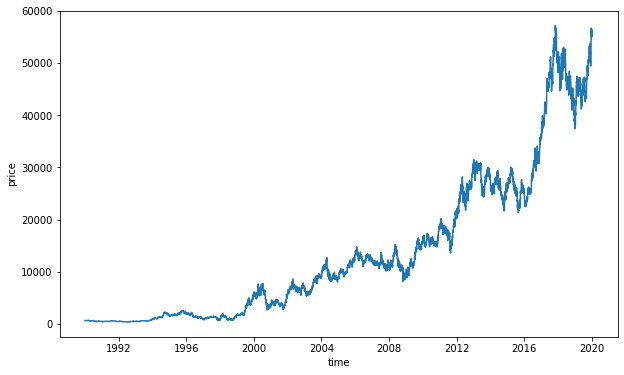

In [6]:
df = df_price.loc[df_price['연도']>=1990]

plt.figure(figsize=(10, 6))
sns.lineplot(y=df['종가'], x=df['일자'])
plt.xlabel('time')
plt.ylabel('price')

## Normalization

딥러닝 모델이 학습을 잘하기 위해서는 정규화 해주는 작업이 필요합니다. sklearn 패키지에 있는 MinMaxScaler를 활용하여 전체 학습 데이터를 Normalize 해 주도록 하겠습니다.

In [7]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scale_cols = ['시가', '고가', '저가', '종가', '거래량']
df_scaled = scaler.fit_transform(df[scale_cols])

df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = scale_cols

df_scaled.head(10)

,시가,고가,저가,종가,거래량
0,0.968482,0.980394,0.979423,0.975012,0.030291
1,0.954474,0.966389,0.961684,0.969733,0.031470
2,0.973735,0.983895,0.967005,0.969733,0.047217
3,0.964980,0.973391,0.968779,0.964454,0.039781
4,0.977237,0.983895,0.981197,0.975012,0.025585
5,0.968482,0.989146,0.977649,0.987330,0.037698
6,0.950972,0.962888,0.958136,0.967973,0.029530
7,0.966731,0.968139,0.965232,0.960934,0.036337
8,0.975486,0.980394,0.970553,0.969733,0.030124
9,0.975486,0.982144,0.979423,0.978531,0.037032


MinMaxScaler를 해주면 전체 데이터는 0, 1사이의 값을 갖도록 해줍니다.

## 학습을 시킬 데이터 셋 생성

여기서 window_size를 정의하여 학습 데이터를 생성할 예정입니다. window_size는 내가 얼마동안(기간)의 주가 데이터에 기반하여 다음날 종가를 예측할 것인가를 정하는 parameter 입니다. 즉 내가 과거 20일을 기반으로 내일 데이터를 예측한다라고 가정했을 때는 window_size=20이 됩니다. 저는 과거 20일을 기준으로 그 다음날의 데이터를 예측해 보도록 하겠습니다.

TEST_SIZE = 200은 학습은 과거부터 200일 이전의 데이터를 학습하게 되고, TEST를 위해서 이후 200일의 데이터로 모델이 주가를 예측하도록 한 다음, 실제 데이터와 오차가 얼마나 있는지 확인해 보도록 하겠습니다.

In [8]:
TEST_SIZE = 200
train = df_scaled[:-TEST_SIZE]
test = df_scaled[-TEST_SIZE:]

In [9]:
train.shape, test.shape

((7628, 5), (200, 5))

In [10]:
def make_dataset(data, label, window_size=20):
    feature_list = []
    label_list = []
    for i in range(len(data) - window_size):
        feature_list.append(np.array(data.iloc[i:i+window_size]))
        label_list.append(np.array(label.iloc[i+window_size]))
    return np.array(feature_list), np.array(label_list)

위의 함수는 정해진 window_size에 기반하여 20일 기간의 데이터 셋을 묶어 주는 역할을 합니다.

즉, 순차적으로 20일 동안의 데이터 셋을 묶고, 이에 맞는 label (예측 데이터)와 함께 return해 줍니다.

In [11]:
feature_cols = ['시가', '고가', '저가', '거래량']
label_cols = ['종가']

train_feature = train[feature_cols]
train_label = train[label_cols]
test_feature = test[feature_cols]
test_label = test[label_cols]

# train dataset
train_feature, train_label = make_dataset(train_feature, train_label, 20)

In [12]:
np.shape(train_feature), np.shape(train_label)

((7608, 20, 4), (7608, 1))

In [13]:
from sklearn.model_selection import train_test_split
x_train, x_valid, y_train, y_valid = train_test_split(train_feature, train_label, test_size=0.2)

x_train.shape, x_valid.shape

((6086, 20, 4), (1522, 20, 4))

In [14]:
# test dataset (실제 예측 해볼 데이터)
test_feature, test_label = make_dataset(test_feature, test_label, 20)
test_feature.shape, test_label.shape

((180, 20, 4), (180, 1))

자, 이제 학습해야할 데이터 셋은 모두 준비가 되었습니다. 이젠 모델에 학습을 시켜보고 evaluation을 해볼 차례입니다.

## Keras를 활용한 LSTM 모델 생성

In [15]:
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequential()
model.add(LSTM(16, 
               input_shape=(train_feature.shape[1], train_feature.shape[2]), 
               activation='relu', 
               return_sequences=False)
          )
model.add(Dense(1))

모델은 매우 간단한 모델을 적용하였습니다. 이미 우리의 feature 데이터의 복잡도가 그렇게 크지 않고 학습해야할 데이터도 10,000개 이하 수준이기 때문에 아주 단순한 모델로도 충분히 좋은 성능을 기대해 볼 수 있습니다. 

오히려 **너무 복잡한 모델이 과적합을 유발하고, 학습도 잘 되지 못하는 결과를 낳을 수 있습니다.**

In [16]:
import os

MODEL_DIR = './model/' #모델을 저장하는 폴더
if not os.path.exists(MODEL_DIR): # 만일 위의 폴더가 존재하지 않으면
  os.mkdir(MODEL_DIR) # 이 이름의 폴더를 만들어 줌

model_path='./model/'

from keras.callbacks import ModelCheckpoint

In [17]:
model.compile(loss='mean_squared_error', optimizer='adam')
early_stop = EarlyStopping(monitor='val_loss', patience=5)
filename = os.path.join(model_path, 'tmp_checkpoint.h5')
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

history = model.fit(x_train, y_train, 
                    epochs=200, 
                    batch_size=16,
                    validation_data=(x_valid, y_valid), 
                    callbacks=[early_stop, checkpoint])

Epoch 1/200
381/381 [==============================] - 25s 10ms/step - loss: 0.0166 - val_loss: 1.3181e-04

Epoch 00001: val_loss improved from inf to 0.00013, saving model to ./model/tmp_checkpoint.h5
Epoch 2/200
381/381 [==============================] - 3s 8ms/step - loss: 1.1075e-04 - val_loss: 9.4821e-05

Epoch 00002: val_loss improved from 0.00013 to 0.00009, saving model to ./model/tmp_checkpoint.h5
Epoch 3/200
381/381 [==============================] - 3s 8ms/step - loss: 8.7473e-05 - val_loss: 6.7953e-05

Epoch 00003: val_loss improved from 0.00009 to 0.00007, saving model to ./model/tmp_checkpoint.h5
Epoch 4/200
381/381 [==============================] - 3s 8ms/step - loss: 6.9235e-05 - val_loss: 7.8515e-05

Epoch 00004: val_loss did not improve from 0.00007
Epoch 5/200
381/381 [==============================] - 3s 8ms/step - loss: 7.5513e-05 - val_loss: 8.5119e-05

Epoch 00005: val_loss did not improve from 0.00007
Epoch 6/200
381/381 [==============================] - 3s 8m

Epoch 27번 기준으로 0.00002 의 평균 오차를 확인할 수 있습니다. 그럼, 학습한 모델로 미래 주가 예측을 해보도록 하겠습니다.

In [18]:
# weight 로딩
model.load_weights(filename)

# 예측
pred = model.predict(test_feature)

## 실제데이터와 예측한 데이터 시각화

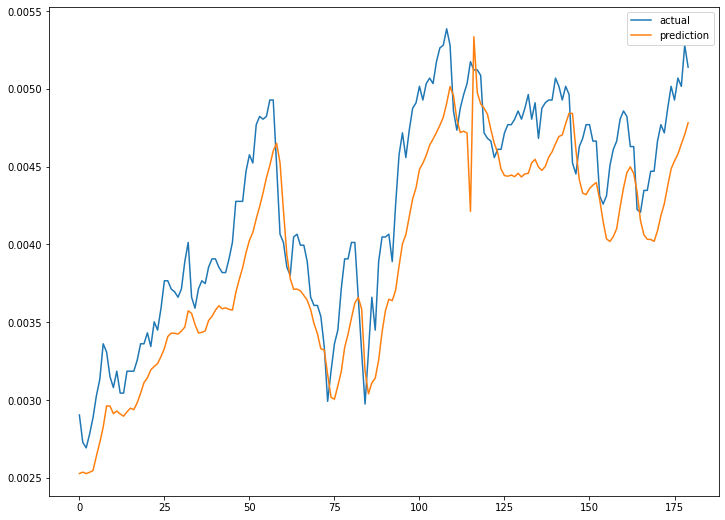

In [19]:
plt.figure(figsize=(12, 9))
plt.plot(test_label, label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

실제 데이터와 어느 정도 비슷한 트렌드를 따라가는 모습입니다.

 

더 많은 데이터, window 사이즈 변경, feature 추가, 모델 수정으로 더 좋은 성능의 모델을 기대해 볼수 있습니다.

최근에는 자연어 처리를 통하여 뉴스 키워드와 주가의 상관관계 분석을 통해 이를 수치화하여 모델에 반영한다면, 훨씬 더 좋은 성능의 예측 모델을 완성할 수 있습니다.